## Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import sys
import ipywidgets as widgets
from IPython.display import display

# Make the src/ directory available
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from planners.IPBasicPRM import BasicPRM
from planners.IPPerfMonitor import IPPerfMonitor
from optimize_path import OptimizeFlyby
from collision_checker import CollisionChecker
from benchmarks import construct_benchmark_environments
from evaluation import calculate_path_length, plot_performance_data, clear_graph_attributes

## Load Environments

In [2]:
env_dict = construct_benchmark_environments()

## Create Planner and Collision Checker for each environment

In [3]:
for name, item in env_dict.items():
    # 1. Initialize a CollisionChecker with the environment
    cc = CollisionChecker(item["env"])

    # 2. Initialize a Planner with the collisionChecker
    planner = BasicPRM(cc)

    # 3. Construct the NetworkX Graph from the predefined solution path
    G = nx.Graph()

    node_names = []

    for i, coord in enumerate(item["smooth_path"]):
        # Determine the name based on position in the list
        if i == 0:
            n = "start"
        elif i == len(item["smooth_path"]) - 1:
            n = "goal"
        else:
            n = f"{i}" # Naming middle nodes generically
        
        node_names.append(n)
        
        # Add node with the 'pos' attribute
        G.add_node(n, pos=coord)

    # Add edges connecting each node to the next
    for i in range(len(node_names) - 1):
        current_node = node_names[i]
        next_node = node_names[i+1]
        G.add_edge(current_node, next_node)

    # 4. Inject the constructed graph into the Planner instance
    planner.graph = G
    
    # 5. Add the node names and the planner to the environment dictionary
    env_dict[name]["solution_node_names"] = node_names
    env_dict[name]["planner"] = planner
    del env_dict[name]["smooth_path"]

## Show the Environments

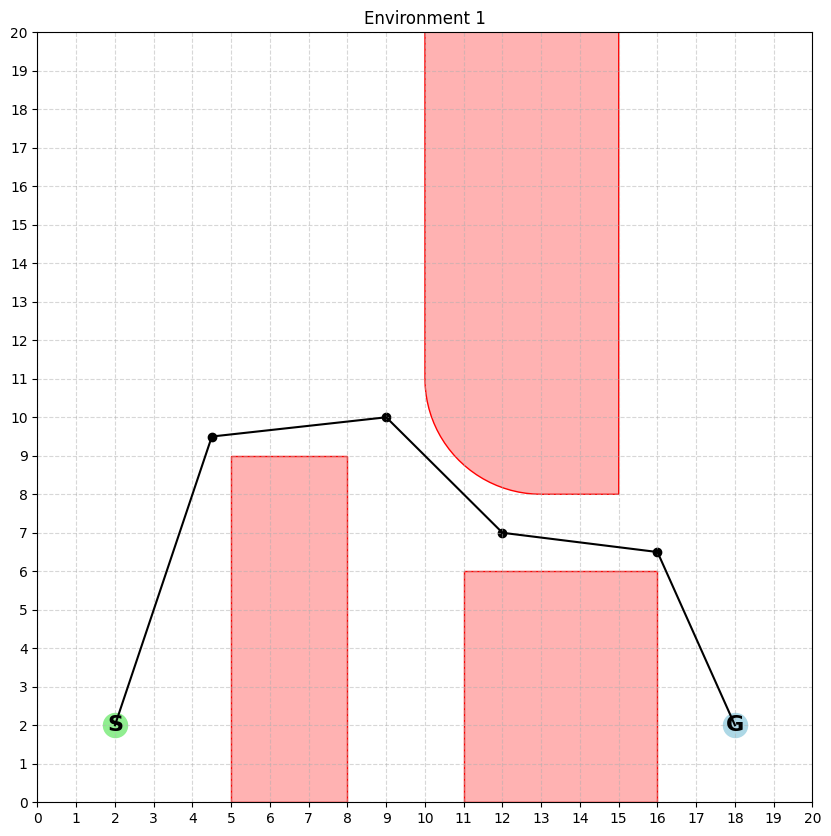

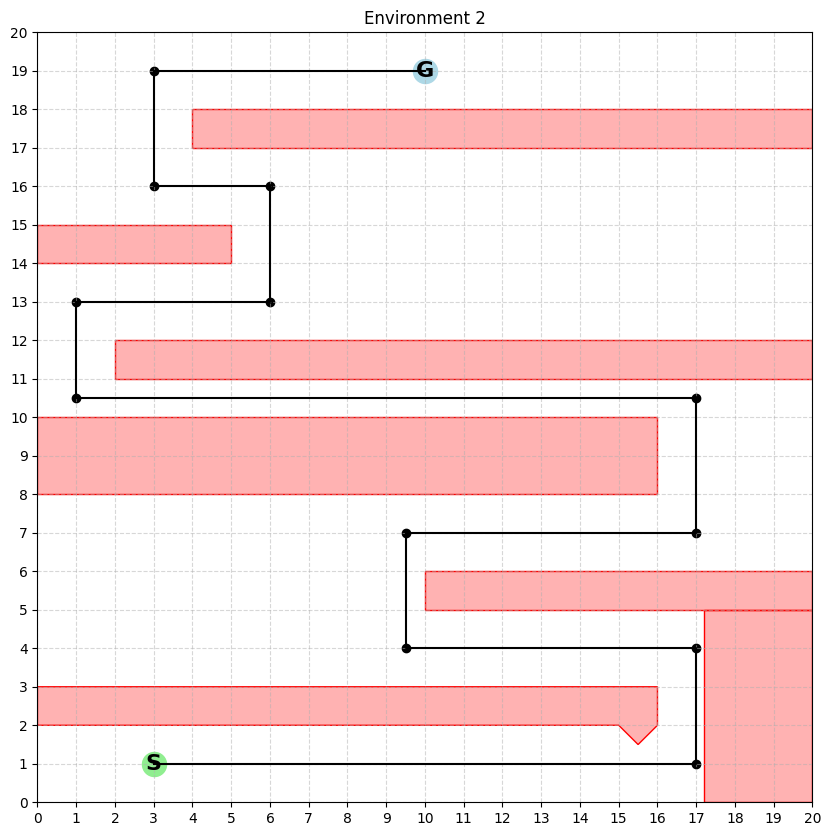

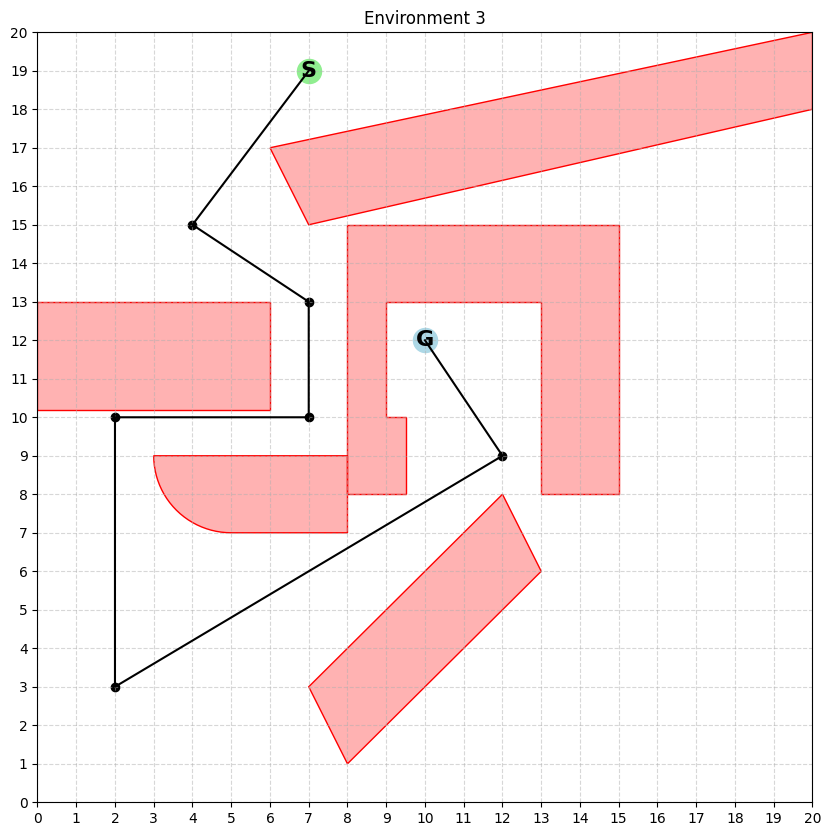

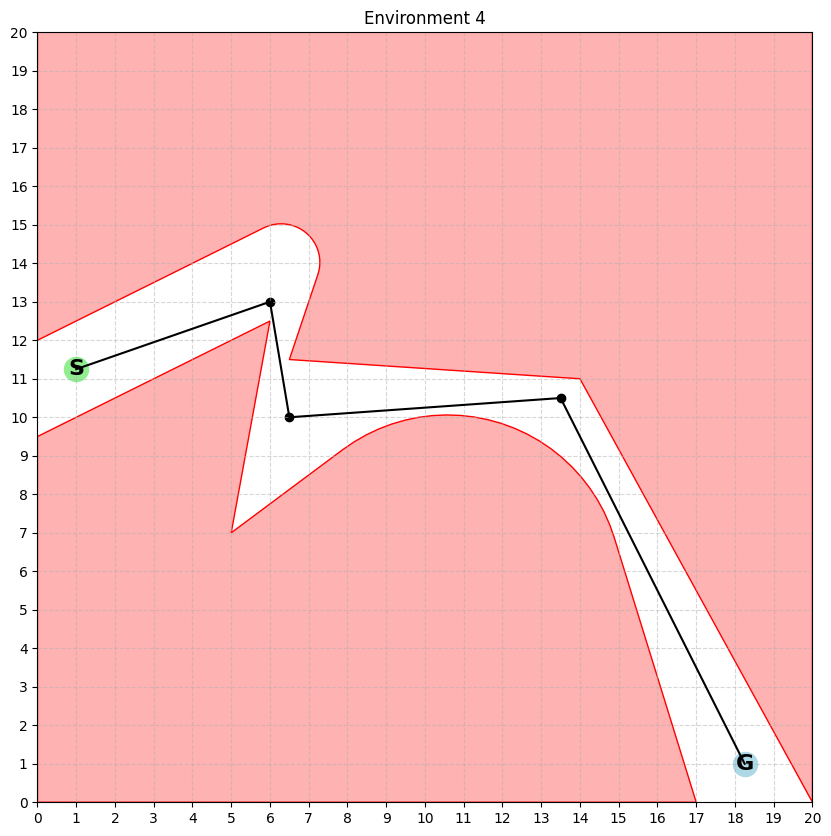

In [4]:
for name, item in env_dict.items():
    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc = planner._collisionChecker

    # Extract the positions of the nodes in the solution path
    pos = [planner.graph.nodes[node_name]["pos"] for node_name in node_names]

    # Draw the obstacles
    ax = cc.draw_enviroments()

    # Draw the path
    ax = cc.draw_path(pos, ax=ax)

    # Set the title
    ax.set_title(f"Environment {name}")

    # Show the plot
    plt.show()

## Optimize the path by setting a radius $r$

### Configure the radius and step by using the sliders

In [5]:
r_slider = widgets.FloatSlider(
    value=0.3,      # Default
    min=0.02, 
    max=0.49, 
    step=0.01,
    description='r:',
    continuous_update=False
)

r_step_slider = widgets.FloatSlider(
    value=0.02,      # Default
    min=0.01, 
    max=0.1, 
    step=0.01,
    description='r step:',
    continuous_update=False
)



display(r_slider)
display(r_step_slider)

FloatSlider(value=0.3, continuous_update=False, description='r:', max=0.49, min=0.02, step=0.01)

FloatSlider(value=0.02, continuous_update=False, description='r step:', max=0.1, min=0.01, step=0.01)

### Run the optimization using the value from the slider

----------------------------------------
Optimizing Environment 1 with config:
    r_init: 0.38
    r_step: 0.02
----------------------------------------


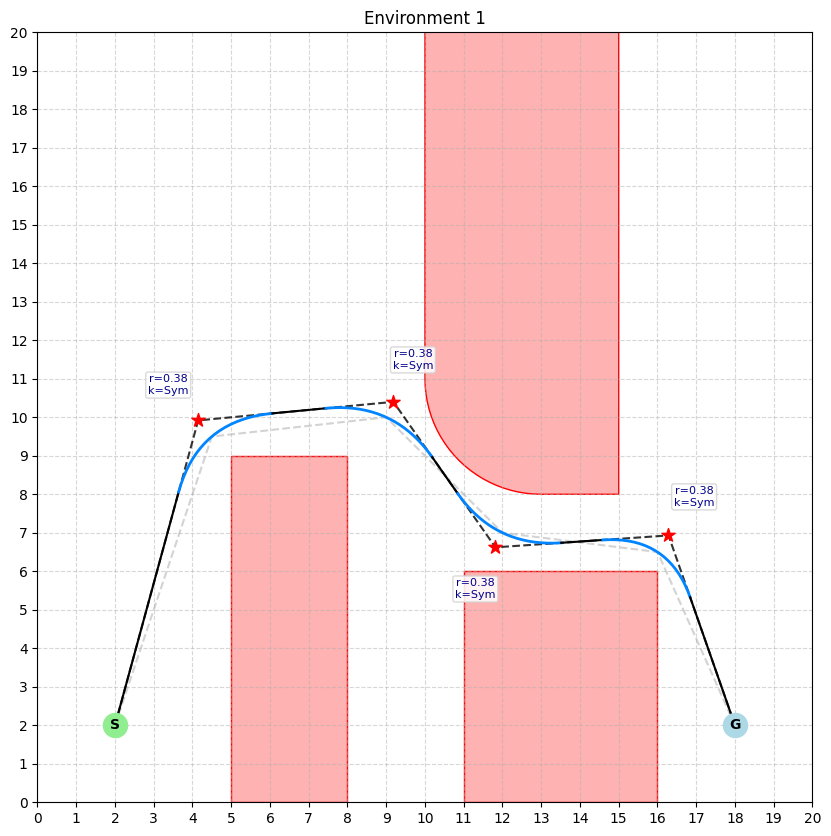

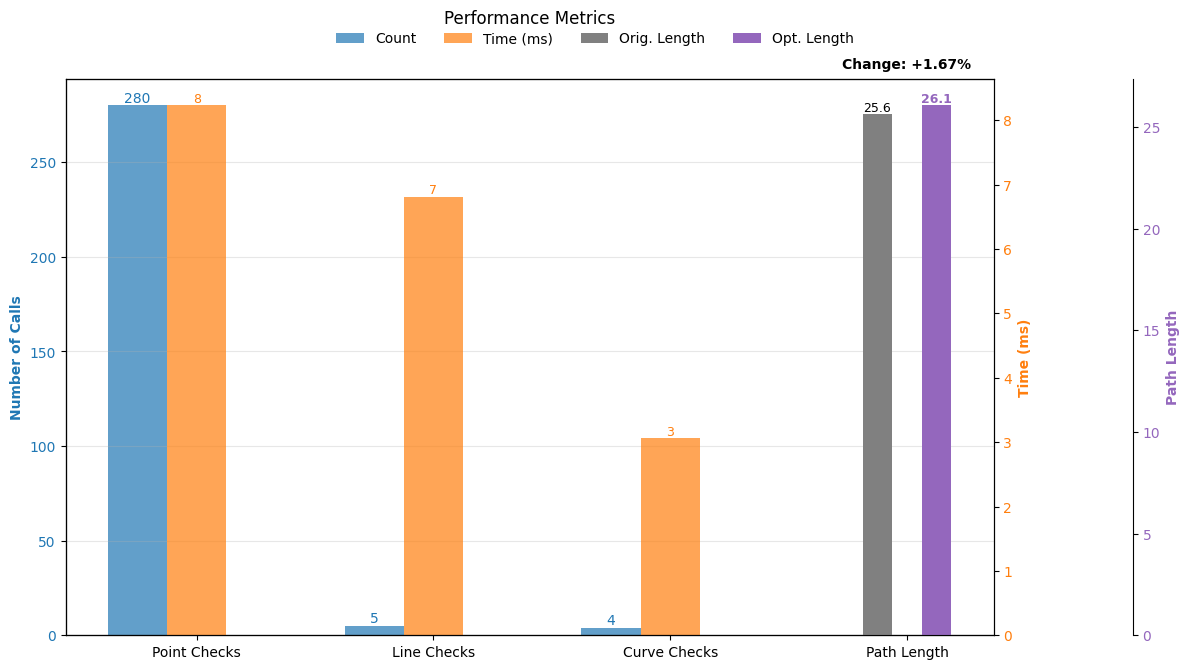

----------------------------------------
Optimizing Environment 2 with config:
    r_init: 0.38
    r_step: 0.02
----------------------------------------


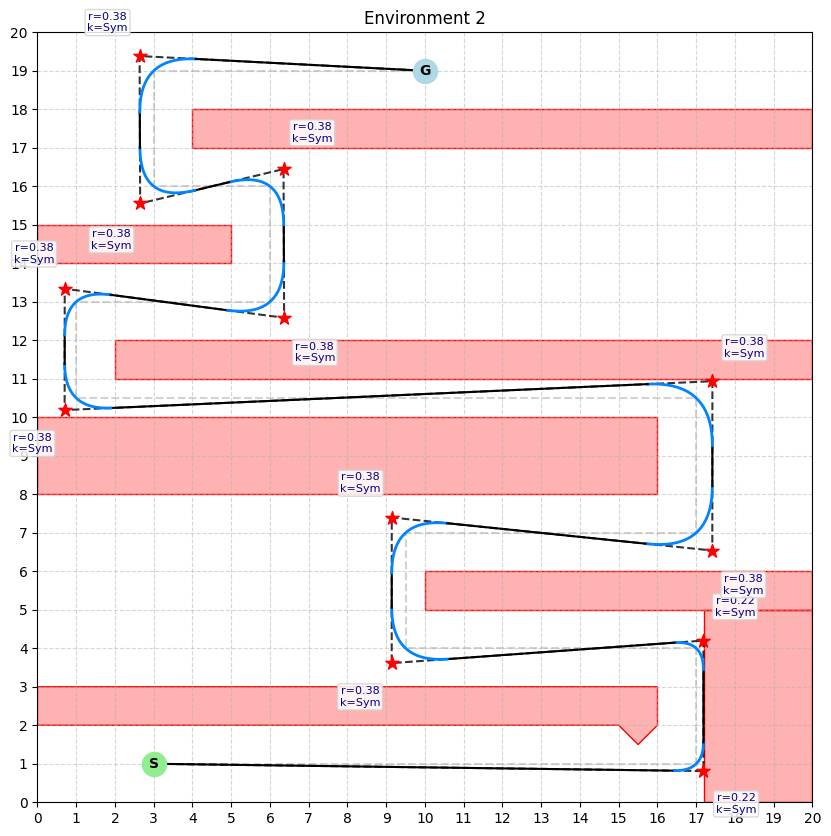

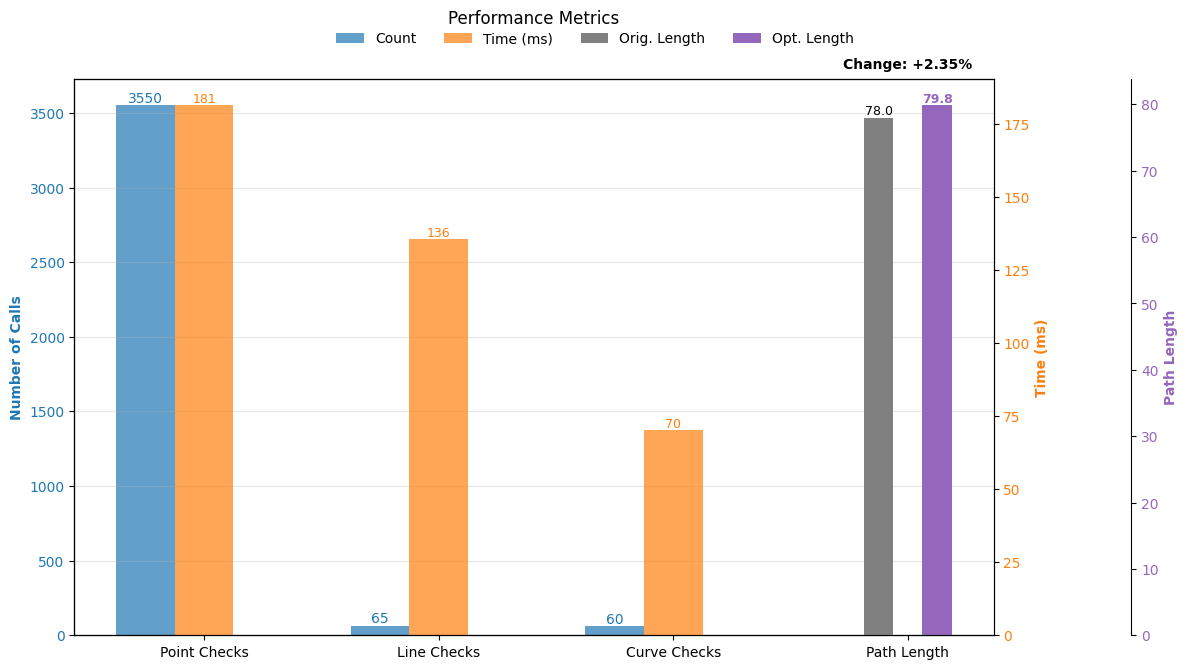

----------------------------------------
Optimizing Environment 3 with config:
    r_init: 0.38
    r_step: 0.02
----------------------------------------


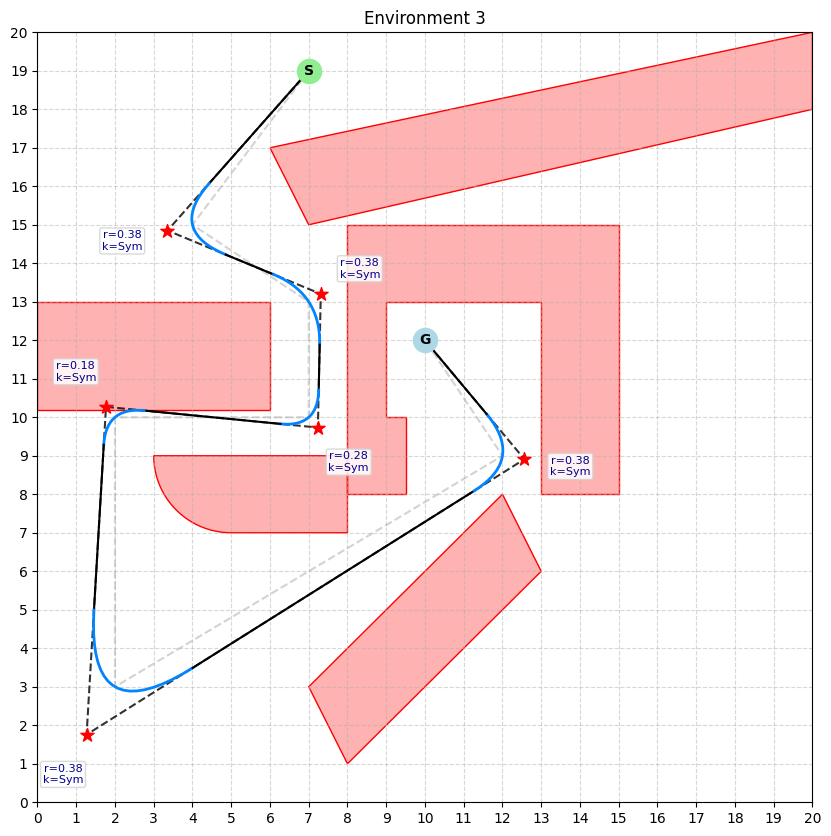

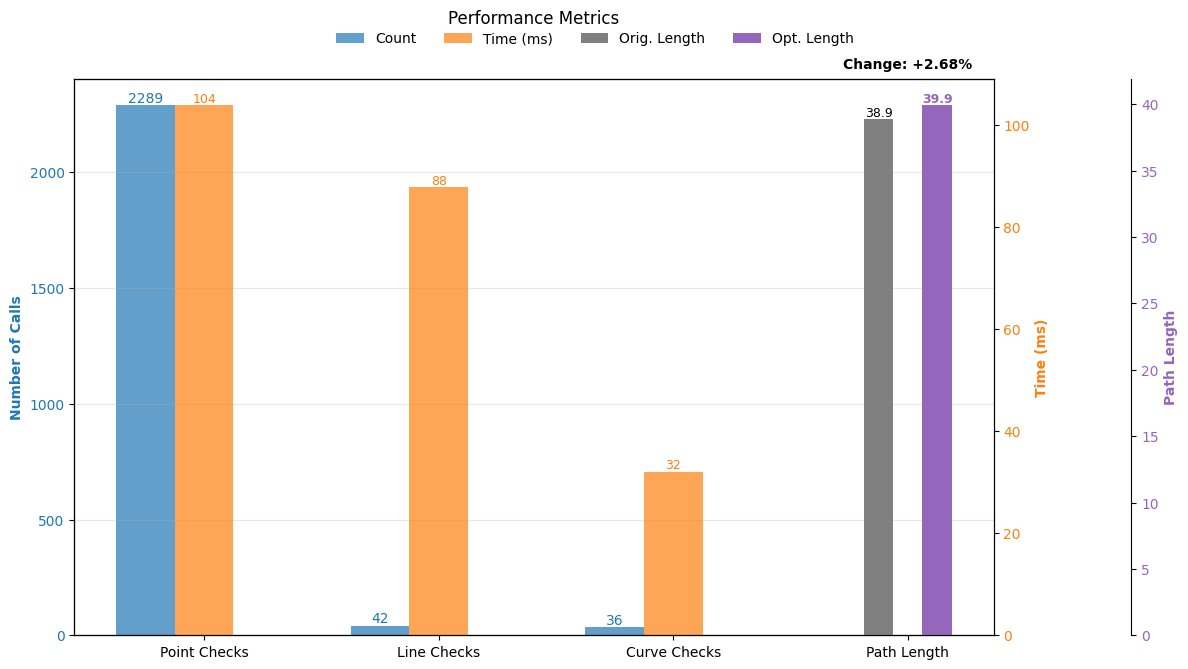

----------------------------------------
Optimizing Environment 4 with config:
    r_init: 0.38
    r_step: 0.02
----------------------------------------


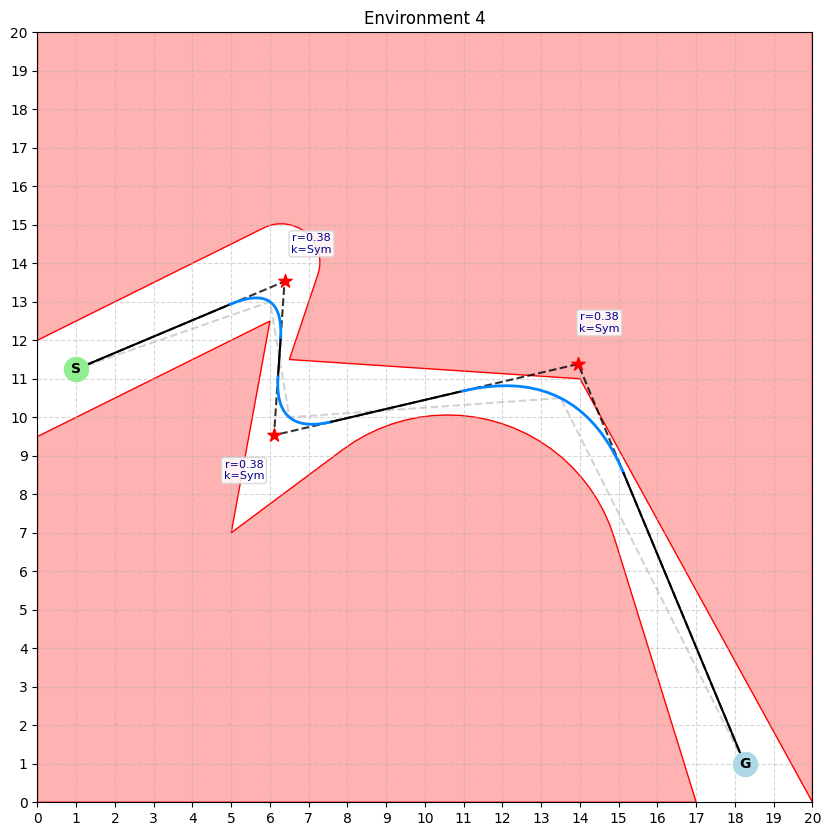

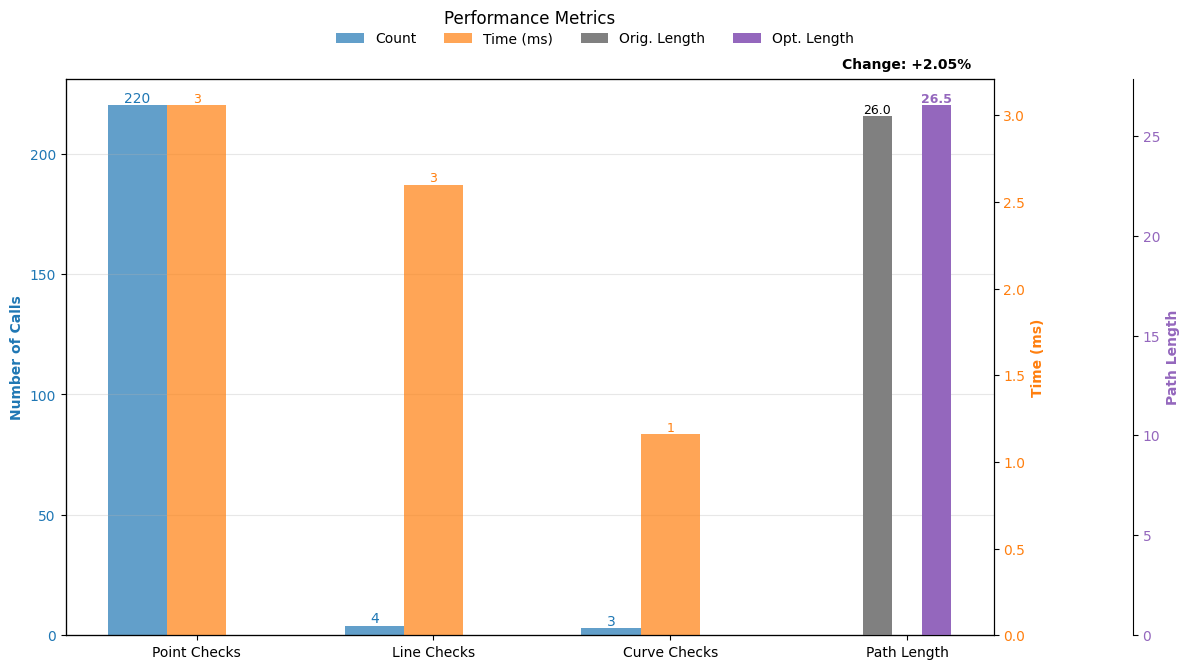

In [7]:
# Configure the Optimizer with slider values
config = {
    'r_init': round(r_slider.value, 2),
    'r_step': round(r_step_slider.value, 2),
}


for name, item in env_dict.items():
    print(f"{40 * '-'}")
    print(f"Optimizing Environment {name} with config:")
    print(f"    r_init: {config['r_init']}")
    print(f"    r_step: {config['r_step']}")
    print(f"{40 * '-'}")


    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc: CollisionChecker = planner._collisionChecker

    # Initialize the Optimizer
    optimizer = OptimizeFlyby()

    # Clear the Performance Monitor
    IPPerfMonitor.clearData()

    # Clear graph attributes
    clear_graph_attributes(planner)

    # Run the optimizer
    results = optimizer.optimizePath(node_names, planner, config)

    # Get the performance data
    df = IPPerfMonitor.dataFrame

    # Extract the performance data for plotting
    df = IPPerfMonitor.dataFrame()
    stats = {}
    target_funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    
    for f in target_funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {
                'count': len(f_data), 
                'time': f_data['time'].sum()
            }
        else:
            stats[f] = {'count': 0, 'time': 0.0}

    # Calculate original path length
    len_orig = calculate_path_length(planner, node_names, use_curves=False)

    # Calculate optimized path lengthe (of rounded path)
    len_opt = calculate_path_length(planner, node_names, use_curves=True)

    # Draw the obstacles
    ax = cc.draw_enviroments()

    # Draw the optimized path
    ax = cc.draw_optimized_path(results, planner, ax)

    # Set the title
    ax.set_title(f"Environment {name}")

    # Show the plot
    plt.show()

    # Plot the performance data
    plot_performance_data(stats, len_orig, len_opt)

    



## Optimize the path by setting a radius $r$ and a global asymmetry factor $k$

### Configure the radius and step by using the sliders

In [ ]:
r_slider = widgets.FloatSlider(
    value=0.3,      # Default
    min=0.02, 
    max=0.49, 
    step=0.01,
    description='r:',
    continuous_update=False
)

r_step_slider = widgets.FloatSlider(
    value=0.02,      # Default
    min=0.01, 
    max=0.1, 
    step=0.01,
    description='r step:',
    continuous_update=False
)

k_slider = widgets.FloatSlider(
    value=1.0,      # Default
    min=0.1, 
    max=3.0, 
    step=0.2,
    description='k:',
    continuous_update=False
)


display(r_slider)
display(r_step_slider)
display(k_slider)

In [ ]:
# Configure the Optimizer with slider values
config = {
    'r_init': round(r_slider.value, 2),
    'r_step': round(r_step_slider.value, 2),
    'k': round(k_slider.value, 2)
}


for name, item in env_dict.items():
    print(f"{40 * '-'}")
    print(f"Optimizing Environment {name} with config:")
    print(f"    r_init: {config['r_init']}")
    print(f"    r_step: {config['r_step']}")
    print(f"    k: {config['k']}")
    print(f"{40 * '-'}")

    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc: CollisionChecker = planner._collisionChecker

    # Initialize the Optimizer
    optimizer = OptimizeFlyby()

    # Clear the Performance Monitor
    IPPerfMonitor.clearData()
    
    # Clear graph attributes
    clear_graph_attributes(planner)

    # Run the optimizer
    results = optimizer.optimizePath(node_names, planner, config)

    # Get the performance data
    df = IPPerfMonitor.dataFrame

    # Extract the performance data for plotting
    df = IPPerfMonitor.dataFrame()
    stats = {}
    target_funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    
    for f in target_funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {
                'count': len(f_data), 
                'time': f_data['time'].sum()
            }
        else:
            stats[f] = {'count': 0, 'time': 0.0}

    # Calculate original path length
    len_orig = calculate_path_length(planner, node_names, use_curves=False)

    # Calculate optimized path lengthe (of rounded path)
    len_opt = calculate_path_length(planner, node_names, use_curves=True)

    # Draw the obstacles
    ax = cc.draw_enviroments()

    # Draw the optimized path
    ax = cc.draw_optimized_path(results, planner, ax)

    # Set the title
    ax.set_title(f"Environment {name}")

    # Show the plot
    plt.show()

    # Plot the performance data
    plot_performance_data(stats, len_orig, len_opt)
